# Kermack - McKendrick model of Epidemics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

### Functions to download data and return tables

In [2]:
def rettable(url):
    tbls = pd.read_html(url)
    lst = []
    for t in tbls:
        return (t)
    return ()

def cleantbl(df, country):
    new = df[df['Country/Region'] == country]
    new = new.groupby('Country/Region').agg('sum')
    new = new.reset_index()
    newT = new.T
    newTH = newT[5:]
    newTH = newTH.reset_index()
    newTH.columns = ['Date', 'Cases']
    newTH['Date'] = pd.to_datetime(newTH['Date'], infer_datetime_format = True)
    newTH['Cases'] = newTH['Cases'].astype(int)
    newTH['LogCases'] = newTH['Cases'].apply(lambda x: np.log(1+x))
    return (newTH)

In [3]:
## Read data for Italy
url = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = rettable(url)
df.head()

,Unnamed: 0,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,NaN,Albania,41.1533,20.1683,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


In [4]:
## Get data for ITALY
italy = cleantbl(df, 'Italy')
italy.head()

,Date,Cases,LogCases
0,2020-01-23,0,0.0
1,2020-01-24,0,0.0
2,2020-01-25,0,0.0
3,2020-01-26,0,0.0
4,2020-01-27,0,0.0


In [5]:
def after100cases(df):
    '''
    function to return cases after 100
    '''
    df1 = df[df['Cases'] >= 100]
    df1['Days'] = 0
    df1['Days'] = df1['Date'].apply(lambda x: (x - df1['Date'].iloc[0]).days)
    return (df1)

def basicplots(df):    
    plt.plot(df['Date'], df['Cases'])
    plt.xticks(rotation=90)
    plt.yscale("log")
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()
    
    df1 = after100cases(df)
    plt.plot(df1['Days'], df1['Cases'])
    plt.yscale("log")
    plt.xlabel('Days after 100th case')
    plt.grid(True)
    plt.show()
    
    return(df1)

/home/srivallabha/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


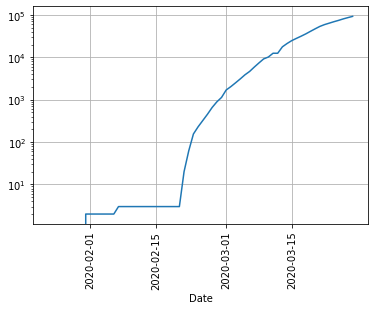

/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


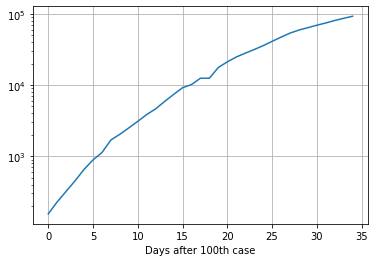

,Date,Cases,LogCases,Days
31,2020-02-23,155,5.049856,0
32,2020-02-24,229,5.438079,1
33,2020-02-25,322,5.777652,2
34,2020-02-26,453,6.118097,3
35,2020-02-27,655,6.486161,4


In [6]:
italy100 = basicplots(italy)
italy100.head()

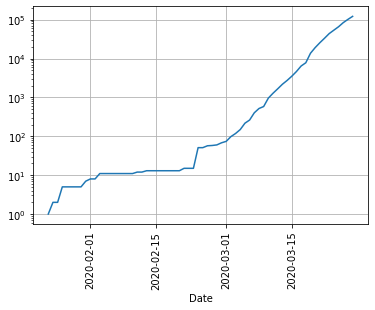

/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


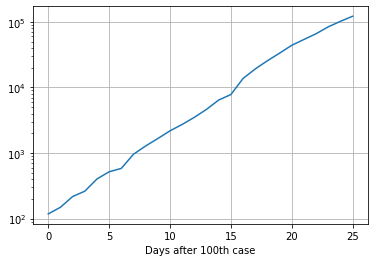

In [7]:
usa = cleantbl(df, 'US')
usa100 =basicplots(usa)

## SEIR modeling
Ref: https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296

In [8]:
#Extension to SEIR model
# The SEIR model differential equations.
def derivseir(y, t, N, beta, alpha, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [25]:
def predictcases(df, Population, Infected, beta, days=30):
    '''
    function to estimate beta for the 
    '''
    ###########################################################################
    ## Parameters from literature
    ### Incubation period 
    ### (https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported)
    DInc = 5 # days
    alpha = 1/DInc
    #print (alpha)

    ### Infectious period
    DInf = 2.3 #days
    gamma = 1/DInf
    #print (gamma)

    ## Infected to suspected ratio
    ## (https://www.who.int/bulletin/online_first/20-255695.pdf)
    isratio = 2.4
    ###########################################################################
    # Total population, N.
    
    # Initial number of infected and recovered individuals, I0 and R0.
    I0 = Infected
    E0 = isratio  * I0  #estimated to be 
    R0 = 0
    N = Population
    
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - E0 - I0 - R0
    
    # A grid of time points (in days)
    t = np.linspace(0, days, days+1)
    #print (t)

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(derivseir, y0, t, args=(N, beta, alpha, gamma))
    S, E, I, R = ret.T
    
    return (t, S, E, I, R)

def esterror(df, t, S, E, I, R):
    y_true = np.array(df['Cases'])
    y_pred = np.array(I[:len(y_true)] + R[:len(y_true)])
    #print (len(y_true), len(y_pred))
    
    diff = (y_true - y_pred)/(y_true)
    #print (len(diff))
    
    error = np.sqrt(np.mean(diff**2))
    return (error)

In [92]:
def estbeta(df, pop, infected, days, betamax, betamin, nint=21):
    '''
    function to estimate the best beta for a case
    '''

    maxerror = 1e5
    finalbeta = 0
    
    betalist = list(np.linspace(betamin, betamax, nint))
    print (betalist)

    for betal in betalist:
        print (betal)
        t,S,E,I, R = predictcases(df = df, Population= pop, Infected = infected, beta = betal, days=days)
        #print (t)
        error = esterror(ny100, t, S, E, I, R)
        print (error)
        if (error < maxerror): 
            finalbeta = betal
            maxerror = error
    print (finalbeta)
    
    return (finalbeta)

In [10]:
italy100.head()

,Date,Cases,LogCases,Days
31,2020-02-23,155,5.049856,0
32,2020-02-24,229,5.438079,1
33,2020-02-25,322,5.777652,2
34,2020-02-26,453,6.118097,3
35,2020-02-27,655,6.486161,4


In [11]:
italy100.tail()

,Date,Cases,LogCases,Days
61,2020-03-24,69176,11.144424,30
62,2020-03-25,74386,11.217036,31
63,2020-03-26,80589,11.297130,32
64,2020-03-27,86498,11.367888,33
65,2020-03-28,92472,11.434672,34


In [42]:
betalist = list(np.linspace(1, 1.2, 21))
print (betalist)

[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.1099999999999999, 1.1199999999999999, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2]


In [43]:
# provide population of Italy
maxerror = 1e5
finalbeta = 0
for betal in betalist:
    print (betal)
    t,S,E,I, R = predictcases(df = italy100, Population= 60550075, Infected = 155, beta = betal, days=35)
    #print (t)
    error = esterror(italy100, t, S, E, I, R)
    print (error)
    if (error < maxerror): 
        finalbeta = betal
        maxerror = error
print (finalbeta)

1.0
0.3983090060227282
1.01
0.38236206269388473
1.02
0.3663216852341463
1.03
0.3503438947091894
1.04
0.3346381696191046
1.05
0.31948239990100796
1.06
0.30523974860547615
1.07
0.29237496812132446
1.08
0.28146475434059587
1.09
0.2731927676932493
1.1
0.2683171595272844
1.1099999999999999
0.2676018129987501
1.1199999999999999
0.271717397285994
1.13
0.2811413301983585
1.14
0.29609866014589326
1.15
0.31656985417712563
1.16
0.34235534890939323
1.17
0.3731615196900324
1.18
0.40867532593018524
1.19
0.4486130527852455
1.2
0.4927443317886241
1.1099999999999999


In [44]:
print (finalbeta)

1.1099999999999999


In [78]:
def plotgraph(df, t, S, E, I, R, country, days=30):
    
    d1 = len(df['Days'])
    d2 = len(t)
    mindays = min(d1, d2)
    
    plt.plot(t, I+R, '-o')
    plt.plot(df['Days'], df['Cases'], '*')
    plt.yscale("log")
    plt.ylim(0, 1e5)
    plt.xlim(0, days)
    plt.legend(['Predicted', 'Actual'])
    plt.grid(True)
    plt.xlabel('Days since 100th case')
    plt.ylabel('Total # of cases')
    plt.title(country)
    plt.show()
    return ()


/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


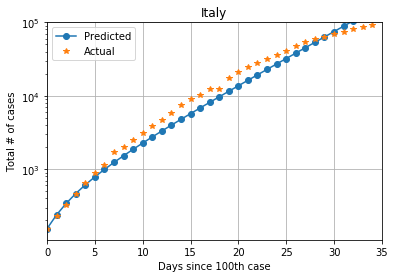

()

In [56]:
t, S, E, I, R = predictcases(df = italy100, Population= 60550075, Infected = 155, beta = finalbeta, days=35)
plotgraph(italy100, t, S, E, I, R, days=35)

In [58]:
##### Estimates for New York state
NY = pd.read_csv('NewYork.csv')

In [59]:
NY.head()

,Unnamed: 0,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,37,2020-03-28,NY,52318.0,103616.0,NaN,10054.0,728.0,155934,48075031d0fd463fcdb0367c15d2fda5b6883bfa,2020-03-28T20:00:00Z,155934,36,209.0,1528.0,2498.0,7683.0,10181.0
1,93,2020-03-27,NY,44635.0,101118.0,NaN,8526.0,519.0,145753,315e7bd97946c9c63a1b2d0648a51d3e73e6b51c,2020-03-27T20:00:00Z,145753,36,134.0,1682.0,16272.0,7377.0,23649.0
2,149,2020-03-26,NY,37258.0,84846.0,NaN,6844.0,385.0,122104,6061eb67c93494274fdee89bdc8bbc80e197f475,2020-03-26T20:00:00Z,122104,36,100.0,3039.0,12178.0,6447.0,18625.0
3,205,2020-03-25,NY,30811.0,72668.0,NaN,3805.0,285.0,103479,4ef31e776a148365f2df74d120980b0c3816eed3,2020-03-25T20:00:00Z,103479,36,75.0,571.0,7063.0,5146.0,12209.0
4,261,2020-03-24,NY,25665.0,65605.0,NaN,3234.0,210.0,91270,de78deaaa130f496c090f80e6ce48ae3a80aca2e,2020-03-24T20:00:00Z,91270,36,96.0,599.0,8191.0,4790.0,12981.0


In [64]:
NYC = NY[['date', 'positive']]
NYC.columns = ['Date', 'Cases']
NYC['Date'] = pd.to_datetime(NYC['Date'])
NYC = NYC.sort_values('Date')
NYC.head()

/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Cases
24,2020-03-04,6.0
23,2020-03-05,22.0
22,2020-03-06,33.0
21,2020-03-07,76.0
20,2020-03-08,105.0


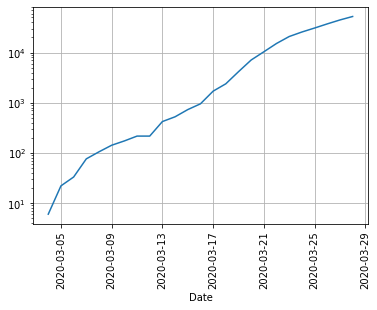

/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


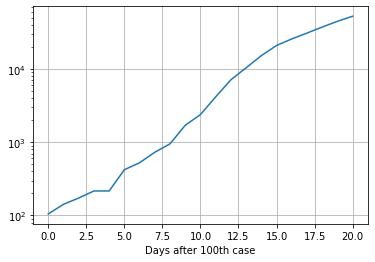

In [66]:
ny100 = basicplots(NYC)

In [84]:
ny100

,Date,Cases,Days
20,2020-03-08,105.0,0
19,2020-03-09,142.0,1
18,2020-03-10,173.0,2
17,2020-03-11,216.0,3
16,2020-03-12,216.0,4
15,2020-03-13,421.0,5
14,2020-03-14,524.0,6
13,2020-03-15,729.0,7
12,2020-03-16,950.0,8
11,2020-03-17,1700.0,9


In [81]:
ny100

,Date,Cases,Days
20,2020-03-08,105.0,0
19,2020-03-09,142.0,1
18,2020-03-10,173.0,2
17,2020-03-11,216.0,3
16,2020-03-12,216.0,4
15,2020-03-13,421.0,5
14,2020-03-14,524.0,6
13,2020-03-15,729.0,7
12,2020-03-16,950.0,8
11,2020-03-17,1700.0,9


In [98]:
nybeta = estbeta(ny100, pop=19453561, infected=105, days=30, betamin=1.4, betamax=1.6, nint=21)

[1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6]
1.4
0.5462315408543833
1.41
0.5450201083522833
1.42
0.5438961885650597
1.43
0.5428662865471171
1.44
0.541937213243276
1.45
0.5411161171728841
1.46
0.5404104728393642
1.47
0.5398280891680385
1.48
0.5393771124050606
1.49
0.5390660288389161
1.5
0.5389036588168469
1.51
0.5388991637433006
1.52
0.5390620359054621
1.53
0.5394020940392975
1.54
0.539929475109023
1.55
0.5406546237944412
1.56
0.541588279619844
1.57
0.5427414616851851
1.58
0.5441254512723378
1.59
0.5457517710340274
1.6
0.5476321632658456
1.51


/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


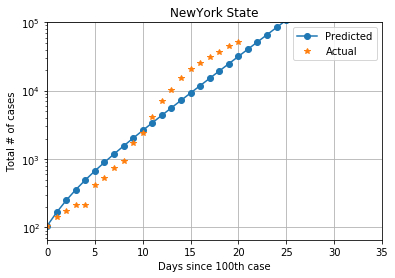

()

In [101]:
t,S,E,I, R = predictcases(df = ny100, Population= 19453561, Infected = 105, beta = nybeta, days=35)
t2,S2,E2,I2, R2 = predictcases(df = ny100, Population= 19453561, Infected = 105, beta = 1.1, days=35)
plotgraph(ny100, t, S, E, I, R, 'NewYork State', days=35)

/home/srivallabha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


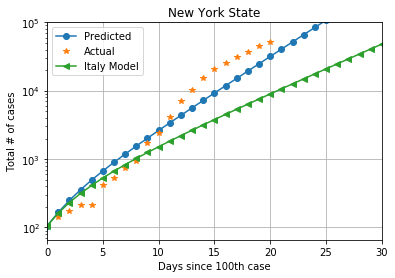

SyntaxError: 'return' outside function (<ipython-input-104-b8271fd6c9d0>, line 13)

In [104]:
plt.plot(t, I+R, '-o')
plt.plot(ny100['Days'], ny100['Cases'], '*')
plt.plot(t, I2+R2, '-<')
plt.yscale("log")
plt.ylim(0, 1e5)
plt.xlim(0, 30)
plt.legend(['Predicted', 'Actual', 'Italy Model'])
plt.grid(True)
plt.xlabel('Days since 100th case')
plt.ylabel('Total # of cases')
plt.title('New York State')
plt.show()